# Dataset
This notebook organize and divide [CAPES](https://figshare.com/articles/A_Parallel_Corpus_of_Thesis_and_Dissertations_Abstracts/5995519/2) dataset

# Import Cell

In [ ]:
! pip install langdetect 
! pip install swifter

In [8]:
from glob import glob
import os

import pandas as pd
import swifter

import numpy as np
from matplotlib import pyplot as plt 

from tqdm.notebook import tnrange, tqdm_notebook

import torch
from torch.distributions.multinomial import Multinomial
from torch.nn import CosineSimilarity
import torch.nn.functional as F
from langdetect import detect
from torchtext.vocab import GloVe
import string

%matplotlib inline

# Reading capes Dataset

Downloading data

In [ ]:
! wget -nc -O /work/datasets/capes/capes.tar.gz https://ndownloader.figshare.com/files/14015837
! tar -xzf /work/datasets/capes/capes.tar.gz

In [9]:
eng_capes_path = "/work/datasets/capes/en_pt.en"
pt_capes_path = "/work/datasets/capes/en_pt.pt"

eng_capes = []
with open(eng_capes_path, 'r') as file:
    eng_capes = file.readlines()
    
pt_capes = []
with open(pt_capes_path, 'r') as file:
    pt_capes = file.readlines()

In [10]:
eng_capes[0]

'in this thesis we present two distinct research lines, namely, the first, referring to chapters 2 and 3, apply statistical techniques to the analysis of synthetic aperture radar (sar) images, and the second, referring to chapter 4, we examined problems concerning parameter estimation by maximum likelihood in exponential-poisson distribution.\n'

In [11]:
pt_capes[0]

'nessa tese apresentamos duas linhas de pesquisa distintas, a saber, na primeira, referente aos capítulos 1 e 3 aplicamos técnicas estatísticas à análise de imagens do satélite de abertura sintética (sar) e, na segunda, referente ao capítulo 2, examinamos problemas relativos à estimação de parâmetros por máxima verossimilhança na distribuição exponencial-poisson.\n'

## Analyzing capes Dataset with panda

In [12]:
capes = pd.DataFrame((zip(eng_capes, pt_capes)), 
               columns =['ENG', 'PT']) 

In [13]:
capes.describe()

,ENG,PT
count,1157610,1157610
unique,1155267,1154916
top,dogs have the nephropathy associated with visc...,a presente dissertação foi desenvolvida no âmb...
freq,10,30


In [14]:
# Removing duplicates
capes = capes.drop_duplicates(subset='ENG', keep="first")
capes = capes.drop_duplicates(subset='PT', keep="first")

In [15]:
capes.describe()

,ENG,PT
count,1154256,1154256
unique,1154256,1154256
top,"among the forms of knowledge visualization, in...",neste dissertação apresentamos um protocolo pa...
freq,1,1


In [16]:
# Checking length of each sentence on the dataset
capes['ENG_LENGTH'] = capes.apply( lambda row: len(row['ENG'].split()),axis=1)
capes['PT_LENGTH']  = capes.apply( lambda row: len(row['PT'].split()),axis=1)

In [17]:
# drop to small sentences (size < 30)
capes = capes.mask(capes.ENG_LENGTH < 30 ).dropna()
capes = capes.mask(capes.PT_LENGTH < 30 ).dropna()

In [18]:
capes.describe()

,ENG_LENGTH,PT_LENGTH
count,405344.000000,405344.000000
mean,43.623747,43.880825
std,13.472300,13.136912
min,30.000000,30.000000
25%,34.000000,35.000000
50%,40.000000,40.000000
75%,49.000000,49.000000
max,206.000000,197.000000


In [ ]:
# Remove sentence that are on another language
from langdetect import detect
capes['ENG_LANG'] = capes.swifter.apply( lambda row: detect(row['ENG']) == 'en', axis=1)
capes['PT_LANG']  = capes.swifter.apply( lambda row: detect(row['PT']) == 'pt',axis=1)

In [15]:
# drop  wrong language assigned
capes = capes.mask(capes.ENG_LANG == False ).dropna()
capes = capes.mask(capes.PT_LANG == False ).dropna()

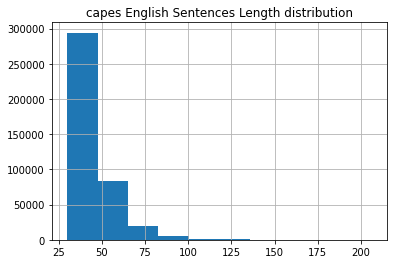

count    404902.000000
mean         43.623329
std          13.471144
min          30.000000
25%          34.000000
50%          40.000000
75%          49.000000
max         206.000000
Name: ENG_LENGTH, dtype: float64

In [16]:
capes['ENG_LENGTH'].hist()
plt.title("capes English Sentences Length distribution")
plt.show()
capes['ENG_LENGTH'].describe()

We can notice that 75% of the sentence has length less then 360

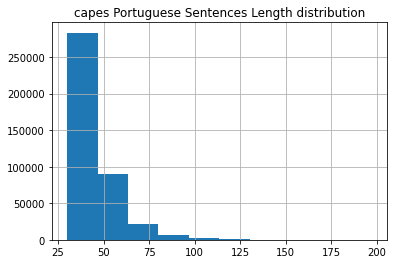

count    404902.000000
mean         43.881270
std          13.135439
min          30.000000
25%          35.000000
50%          40.000000
75%          49.000000
max         197.000000
Name: PT_LENGTH, dtype: float64

In [17]:
capes['PT_LENGTH'].hist()
plt.title("capes Portuguese Sentences Length distribution")
plt.show()
capes['PT_LENGTH'].describe()

In [18]:
capes.drop(['ENG_LENGTH','PT_LENGTH','ENG_LANG','PT_LANG'], axis=1, inplace=True)

In [28]:
# Remove \n char from the end of each sentence
capes = capes.reset_index(drop=True)
capes["ENG"] = capes.apply( lambda row: row['ENG'].replace("\n",""),axis=1)
capes["PT"] = capes.apply( lambda row: row['PT'].replace("\n",""),axis=1)

In [29]:
# Save Sampling
capes.to_pickle("datasets/capes/full_organized_data.pkcl")

# Creating Dataset with Negative Samples
In this section we will compare each English sentence embedding with each pt sentence embedding, using cosine similarity.
After this we will retrieve the top-5 similar sentence of each, notice that we expect that just lexical similarity will be retrieve, this is why we are using a simple model of GloVe to make this comparison.

The Idea is select the most lexical similar sentence from one language to another, but with a very different semantic.

In [21]:
# load Dataset
dataset = pd.read_pickle('/work/datasets/capes/full_organized_data.pkcl')

In [22]:
dataset.describe()

,ENG,PT
count,404902,404902
unique,404902,404902
top,"this theory, differentially of the others, wor...",foram utilizados 72 ratos distribuídos aleator...
freq,1,1


### Loading Glove Vectors to use as word embedding

In [23]:
# glove_vectors is a pytorch vocabulary
# https://github.com/pytorch/text/blob/master/torchtext/vocab.py
glove_vectors = GloVe(name='6B', dim=50, cache='./glove_dir')

vectors = glove_vectors.vectors
glove_dict = glove_vectors.stoi

./glove_dir/glove.6B.zip: 862MB [06:33, 2.19MB/s]                               
100%|█████████▉| 399999/400000 [00:13<00:00, 29039.65it/s]


### Creating Torch Tensors from the words

In [25]:
eng_data  = dataset["ENG"].values
pt_data  = dataset["PT"].values

In [27]:
table = str.maketrans({key: None for key in string.punctuation})
def remove_punctuation(sentence):
    return sentence.translate(table)

def get_sentence_embedding(sentence,dim=50):
    """
    From a input sentence, calculate a sentence embedding.
    The sentence embedding is the mean of each word embedding beloging to the sentence.
    """
    
    # Remove punctuation from the sentence
    sentence = remove_punctuation(sentence)
    
    # Calculate the mean for each word embedding beloging to the sentence
    list_of_embedding =  [ vectors[glove_dict[word]] 
                             for word in sentence.split()
                             if (word in glove_dict)
                         ]
    
    # if we could not find any word in the sentence that is in the vocabulary
    # we return a random value
    if list_of_embedding == []:
        print("Found sentence without Embedding")
        return torch.rand(dim)
        
    # return the sentence embedding mean
    return torch.mean( torch.stack( list_of_embedding) ,axis=0)

In [28]:
eng_vectors = []
for sentence in tqdm_notebook(eng_data):
    eng_vectors.append(get_sentence_embedding(sentence))
eng_vectors = torch.stack(eng_vectors)

Found sentence without Embedding
Found sentence without Embedding
Found sentence without Embedding



In [29]:
pt_vectors = []
for sentence in tqdm_notebook(pt_data):
    pt_vectors.append(get_sentence_embedding(sentence))
pt_vectors = torch.stack(pt_vectors)

Found sentence without Embedding



# Testset
the most similars are retrieved by top_k


In [72]:
cos = CosineSimilarity()
def find_most_similar(query, tensors,index,top_k=200):
    """
    Retrieve most similar sentences
    """
    # Reshape query 
    query = query.unsqueeze(0)
    # Apply cosine similarity between the query and all dataset
    cosine_similarity_between_query_tensors = cos(query,tensors)
    
    # Sort values by similarity: The highest similarity is 1 and lowest -1
    values, indeces = cosine_similarity_between_query_tensors.topk(top_k)
    
    # Get Random sentence that are inside the nucleues
    sampling = Multinomial(total_count=10,logits=values).sample()
    
    # Retrieve selected sentence
    most_similar = indeces.masked_select(sampling.type(torch.bool))
    # remove the translation of the query from the selected ones ( if it is there)
    most_similar = most_similar[most_similar != index]
    
    # Return the top_5 similar result, after the sampling
    return most_similar[:5]

In [ ]:
negative_sentence = {
    'top_1_qeng_pt': [],
    'top_1_qpt_eng': [],
    'top_2_qeng_pt': [],
    'top_2_qpt_eng': [],
    'top_3_qeng_pt': [],
    'top_3_qpt_eng': [],
    'top_4_qeng_pt': [],
    'top_4_qpt_eng': [],
    'top_5_qeng_pt': [],
    'top_5_qpt_eng': []
}
total = len(dataset)
for index,(eng,pt) in tqdm_notebook(dataset.iterrows(),total=total):
    
    # Most lexical similar senentece from pt to eng
    qpt_index = find_most_similar(pt_vectors[index],eng_vectors,index)
    top1,top2,top3,top4,top5 = qpt_index #dataset.ENG.iloc[qpt_index].values
    
    negative_sentence['top_1_qpt_eng'].append(top1.item())
    negative_sentence['top_2_qpt_eng'].append(top2.item())
    negative_sentence['top_3_qpt_eng'].append(top3.item())
    negative_sentence['top_4_qpt_eng'].append(top4.item())
    negative_sentence['top_5_qpt_eng'].append(top5.item())
    
    # Most lexical similar senentece from eng to pt
    qeng_index = find_most_similar(eng_vectors[index],pt_vectors,index)
    top1,top2,top3,top4,top5 = qeng_index #dataset.PT.iloc[qeng_index].values
    
    negative_sentence['top_1_qeng_pt'].append(top1.item())
    negative_sentence['top_2_qeng_pt'].append(top2.item())
    negative_sentence['top_3_qeng_pt'].append(top3.item())
    negative_sentence['top_4_qeng_pt'].append(top4.item())
    negative_sentence['top_5_qeng_pt'].append(top5.item())
    
    with open("/work/datasets/capes/top_k_dataset_status.txt","w") as file:
        file.write(f"{index}/{total}")
        
dataset['top_1_qpt_eng'] = negative_sentence['top_1_qpt_eng']
dataset['top_2_qpt_eng'] = negative_sentence['top_2_qpt_eng']
dataset['top_3_qpt_eng'] = negative_sentence['top_3_qpt_eng']
dataset['top_4_qpt_eng'] = negative_sentence['top_4_qpt_eng']
dataset['top_5_qpt_eng'] = negative_sentence['top_5_qpt_eng']

dataset['top_1_qeng_pt'] = negative_sentence['top_1_qeng_pt']
dataset['top_2_qeng_pt'] = negative_sentence['top_2_qeng_pt']
dataset['top_3_qeng_pt'] = negative_sentence['top_3_qeng_pt']
dataset['top_4_qeng_pt'] = negative_sentence['top_4_qeng_pt']
dataset['top_5_qeng_pt'] = negative_sentence['top_5_qeng_pt']

# Save dataset on disk
dataset.to_pickle("/work/datasets/capes/top_k_dataset.pkcl")
with open("/work/datasets/capes/top_k_dataset_status.txt","w") as file:
        file.write("Done --- ")

In [93]:
dataset = pd.read_pickle("/work/datasets/capes/top_k_dataset.pkcl")

In [121]:
# Removing duplicates

testset = pd.DataFrame()

testset = testset.append(dataset.drop_duplicates(subset='top_1_qeng_pt', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_2_qeng_pt', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_3_qeng_pt', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_4_qeng_pt', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_5_qeng_pt', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_1_qpt_eng', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_2_qpt_eng', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_3_qpt_eng', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_4_qpt_eng', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_5_qpt_eng', keep="first"))


In [122]:
testset = testset.drop_duplicates(subset='ENG', keep="first")
testset = testset.drop_duplicates(subset='PT', keep="first")

In [123]:
len(testset)

7903

In [124]:
from tqdm import tqdm_notebook
for test_index, row in tqdm_notebook(enumerate(testset.iterrows()),total=len(testset )):
    index = row[0]
    
    testset.top_1_qpt_eng.iloc[test_index] = dataset.ENG.iloc[dataset.top_1_qpt_eng.iloc[index]]
    testset.top_2_qpt_eng.iloc[test_index] = dataset.ENG.iloc[dataset.top_2_qpt_eng.iloc[index]]
    testset.top_3_qpt_eng.iloc[test_index] = dataset.ENG.iloc[dataset.top_3_qpt_eng.iloc[index]]
    testset.top_4_qpt_eng.iloc[test_index] = dataset.ENG.iloc[dataset.top_4_qpt_eng.iloc[index]]
    testset.top_5_qpt_eng.iloc[test_index] = dataset.ENG.iloc[dataset.top_5_qpt_eng.iloc[index]]
    testset.top_1_qeng_pt.iloc[test_index] = dataset.PT.iloc[dataset.top_1_qeng_pt.iloc[index]]
    testset.top_2_qeng_pt.iloc[test_index] = dataset.PT.iloc[dataset.top_2_qeng_pt.iloc[index]]
    testset.top_3_qeng_pt.iloc[test_index] = dataset.PT.iloc[dataset.top_3_qeng_pt.iloc[index]]
    testset.top_4_qeng_pt.iloc[test_index] = dataset.PT.iloc[dataset.top_4_qeng_pt.iloc[index]]
    testset.top_5_qeng_pt.iloc[test_index] = dataset.PT.iloc[dataset.top_5_qeng_pt.iloc[index]]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [126]:
testset.describe()

,ENG,PT,top_1_qpt_eng,top_2_qpt_eng,top_3_qpt_eng,top_4_qpt_eng,top_5_qpt_eng,top_1_qeng_pt,top_2_qeng_pt,top_3_qeng_pt,top_4_qeng_pt,top_5_qeng_pt
count,7903,7903,7903,7903,7903,7903,7903,7903,7903,7903,7903,7903
unique,7903,7903,1019,1255,1490,1673,1834,955,1201,1444,1580,1744
top,fifty human dentin slabs were evaluated by pro...,"com base nas teorias de lima (2001, 2004 e 201...",distance education (de) is a type of education...,"guilherme de mello¿s book, a musica no brasil:...",this work is an analysis-interpretation of fiv...,"in the context of brazilian cinema, the northe...","in the context of brazilian cinema, the northe...",dentofacial characteristics of oral breathers ...,a coleta de dados ocorreu em três etapas com a...,métodos: no artigo 1 foi realizada uma busca n...,"n a coleta de dados, utilizaram - se d ois que...",para a coleta dos dados foi utilizada a escala...
freq,1,1,155,81,55,49,44,235,103,66,57,61


In [127]:
testset.to_pickle("/work/datasets/capes/test_set_with_negatives_strings.pkcl")

# Trainset
the most similars are retrieved by top_p (based on Nuclueos Sampling)

In [ ]:
cos = CosineSimilarity()


def find_most_similar(query, tensors,index,top_p=0.8,minimum_sampling_size=500):
    
     
    query = query.unsqueeze(0)
    cosine_similarity_between_query_tensors = cos(query,tensors)
    
    
    sorted_values, indices_values = torch.sort(cosine_similarity_between_query_tensors,descending=True)
    
    
    out_of_sampling_indeces = indices_values.new_ones(indices_values.shape).type(torch.bool)
    sorted_probs = F.softmax(sorted_values, dim=-1)
    
    cumulated_probs = torch.cumsum(sorted_probs,dim=-1)
    out_of_sampling_indeces[ cumulated_probs < top_p ] = False
    out_of_sampling_indeces[... , : minimum_sampling_size] = False
    sorted_probs[out_of_sampling_indeces] = 0
    
    sampling = Multinomial(total_count=10,probs=sorted_probs).sample()
    
    most_similar = indices_values.masked_select(sampling.type(torch.bool))
    most_similar = most_similar[most_similar != index]
    return most_similar[:5]

In [ ]:
negative_sentence = {
    'top_1_qeng_pt': [],
    'top_1_qpt_eng': [],
    'top_2_qeng_pt': [],
    'top_2_qpt_eng': [],
    'top_3_qeng_pt': [],
    'top_3_qpt_eng': [],
    'top_4_qeng_pt': [],
    'top_4_qpt_eng': [],
    'top_5_qeng_pt': [],
    'top_5_qpt_eng': []
}
total = len(dataset)
for index,(eng,pt) in dataset.iterrows():
    
    # Most lexical similar senentece from pt to eng
    qpt_index = find_most_similar(pt_vectors[index],eng_vectors,index)
    top1,top2,top3,top4,top5 = qpt_index #dataset.ENG.iloc[qpt_index].values
    
    negative_sentence['top_1_qpt_eng'].append(top1.item())
    negative_sentence['top_2_qpt_eng'].append(top2.item())
    negative_sentence['top_3_qpt_eng'].append(top3.item())
    negative_sentence['top_4_qpt_eng'].append(top4.item())
    negative_sentence['top_5_qpt_eng'].append(top5.item())
    
    # Most lexical similar senentece from eng to pt
    qeng_index = find_most_similar(eng_vectors[index],pt_vectors,index)
    top1,top2,top3,top4,top5 = qeng_index #dataset.PT.iloc[qeng_index].values
    
    negative_sentence['top_1_qeng_pt'].append(top1.item())
    negative_sentence['top_2_qeng_pt'].append(top2.item())
    negative_sentence['top_3_qeng_pt'].append(top3.item())
    negative_sentence['top_4_qeng_pt'].append(top4.item())
    negative_sentence['top_5_qeng_pt'].append(top5.item())
    
    # Control file to describe the progress of this cell
    with open("datasets/scielo/full_construction_status.txt","w") as file:
        file.write(f"{index}/{total}")
        
dataset['top_1_qpt_eng'] = negative_sentence['top_1_qpt_eng']
dataset['top_2_qpt_eng'] = negative_sentence['top_2_qpt_eng']
dataset['top_3_qpt_eng'] = negative_sentence['top_3_qpt_eng']
dataset['top_4_qpt_eng'] = negative_sentence['top_4_qpt_eng']
dataset['top_5_qpt_eng'] = negative_sentence['top_5_qpt_eng']

dataset['top_1_qeng_pt'] = negative_sentence['top_1_qeng_pt']
dataset['top_2_qeng_pt'] = negative_sentence['top_2_qeng_pt']
dataset['top_3_qeng_pt'] = negative_sentence['top_3_qeng_pt']
dataset['top_4_qeng_pt'] = negative_sentence['top_4_qeng_pt']
dataset['top_5_qeng_pt'] = negative_sentence['top_5_qeng_pt']

dataset.to_pickle("datasets/scielo/full_data_with_negatives.pkcl")

# Control file to describe the progress of this cell
with open("datasets/scielo/full_construction_status.txt","w") as file:
        file.write("Done --- ")

In [ ]:
dataset = pd.read_pickle("/work/datasets/capes/full_data_with_negatives.pkcl")
for row in tqdm_notebook(dataset.iterrows(),total=len(dataset )):
    index = row[0]
    
    dataset.top_1_qpt_eng.iloc[index] = dataset.ENG.iloc[dataset.top_1_qpt_eng.iloc[index]]
    dataset.top_2_qpt_eng.iloc[index] = dataset.ENG.iloc[dataset.top_2_qpt_eng.iloc[index]]
    dataset.top_3_qpt_eng.iloc[index] = dataset.ENG.iloc[dataset.top_3_qpt_eng.iloc[index]]
    dataset.top_4_qpt_eng.iloc[index] = dataset.ENG.iloc[dataset.top_4_qpt_eng.iloc[index]]
    dataset.top_5_qpt_eng.iloc[index] = dataset.ENG.iloc[dataset.top_5_qpt_eng.iloc[index]]
    dataset.top_1_qeng_pt.iloc[index] = dataset.PT.iloc[dataset.top_1_qeng_pt.iloc[index]]
    dataset.top_2_qeng_pt.iloc[index] = dataset.PT.iloc[dataset.top_2_qeng_pt.iloc[index]]
    dataset.top_3_qeng_pt.iloc[index] = dataset.PT.iloc[dataset.top_3_qeng_pt.iloc[index]]
    dataset.top_4_qeng_pt.iloc[index] = dataset.PT.iloc[dataset.top_4_qeng_pt.iloc[index]]
    dataset.top_5_qeng_pt.iloc[index] = dataset.PT.iloc[dataset.top_5_qeng_pt.iloc[index]]
    
dataset.to_pickle("/work/datasets/capes/full_data_with_negatives_strings.pkcl")


In [35]:
TRAIN_DATA = pd.read_pickle("/work/datasets/capes/full_data_with_negatives_strings.pkcl")

In [133]:
TRAIN_DATA.describe()

,ENG,PT,top_1_qpt_eng,top_2_qpt_eng,top_3_qpt_eng,top_4_qpt_eng,top_5_qpt_eng,top_1_qeng_pt,top_2_qeng_pt,top_3_qeng_pt,top_4_qeng_pt,top_5_qeng_pt
count,404902,404902,404902,404902,404902,404902,404902,404902,404902,404902,404902,404902
unique,404902,404902,104960,150973,178267,194153,203136,83199,119324,142567,157176,165330
top,"this theory, differentially of the others, wor...",foram utilizados 72 ratos distribuídos aleator...,the research analyzes the editorial trajectory...,"to obtain refle ctance values, the following o...",this pericope describes the duties performed b...,the results achieved has shown that despite of...,this study aims do conduct a discussion around...,"em 2011, a organização mundial de saúde (oms) ...",no exercício de análise das charges de ziraldo...,"diante do exposto, consideramos que a produção...",esta dissertação discute a relação entre crôni...,"em razão disto, o objetivo deste estudo foi an..."
freq,1,1,33,16,13,12,11,34,16,14,16,13


### Remove from TRAIN_DATA the samples that are in testset

In [134]:
len(TRAIN_DATA)

404902

In [136]:
len(testset)

7903

In [137]:
TRAIN_DATA = TRAIN_DATA.drop(index=testset.index)

In [138]:
len(TRAIN_DATA)

396999

In [142]:
TRAIN_DATA.to_pickle("/work/datasets/capes/TRAINSET_with_negatives_strings.pckl")

# Conclusions and Stats

In [140]:
## TESTSET
testset.describe()

,ENG,PT,top_1_qpt_eng,top_2_qpt_eng,top_3_qpt_eng,top_4_qpt_eng,top_5_qpt_eng,top_1_qeng_pt,top_2_qeng_pt,top_3_qeng_pt,top_4_qeng_pt,top_5_qeng_pt
count,7903,7903,7903,7903,7903,7903,7903,7903,7903,7903,7903,7903
unique,7903,7903,1019,1255,1490,1673,1834,955,1201,1444,1580,1744
top,fifty human dentin slabs were evaluated by pro...,"com base nas teorias de lima (2001, 2004 e 201...",distance education (de) is a type of education...,"guilherme de mello¿s book, a musica no brasil:...",this work is an analysis-interpretation of fiv...,"in the context of brazilian cinema, the northe...","in the context of brazilian cinema, the northe...",dentofacial characteristics of oral breathers ...,a coleta de dados ocorreu em três etapas com a...,métodos: no artigo 1 foi realizada uma busca n...,"n a coleta de dados, utilizaram - se d ois que...",para a coleta dos dados foi utilizada a escala...
freq,1,1,155,81,55,49,44,235,103,66,57,61


In [141]:
# Trainset
TRAIN_DATA.describe()

,ENG,PT,top_1_qpt_eng,top_2_qpt_eng,top_3_qpt_eng,top_4_qpt_eng,top_5_qpt_eng,top_1_qeng_pt,top_2_qeng_pt,top_3_qeng_pt,top_4_qeng_pt,top_5_qeng_pt
count,396999,396999,396999,396999,396999,396999,396999,396999,396999,396999,396999,396999
unique,396999,396999,103476,149191,176096,191818,200665,82457,118460,141430,155807,163875
top,the fenoterol hydrobromide drug is a bronchodi...,a lei nº 12.594/2012 ¿ que institui o sistema ...,the research analyzes the editorial trajectory...,"to obtain refle ctance values, the following o...",this pericope describes the duties performed b...,the results achieved has shown that despite of...,this study aims do conduct a discussion around...,"em 2011, a organização mundial de saúde (oms) ...",com a microscopia eletrônica de varredura (mev...,"diante do exposto, consideramos que a produção...",esta dissertação discute a relação entre crôni...,"em razão disto, o objetivo deste estudo foi an..."
freq,1,1,33,16,13,12,11,33,16,14,16,13


The testset has few data, but its data is lexically similar to the 'ENG'/'PT' sentence
On the other hand, TRAIN_DATA has much more data, with this similarity relaxed, to have more diversity between the query 'ENG'/'PT' and the retrieved sentences.